# iPRules

# Statics

In [1]:
import dask.dataframe as dd
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import metrics


## Load Dataset

In [2]:

from notebooks.IPRules.read_datasets import read_dataset

name = "connect-4"

path = f'../..'
dataset_path_name = f'{path}/data/{name}.csv'
X, y, dataset, target_value_name, pandas_dataset = read_dataset(name, dataset_path_name)

pandas_dataset.head()

,F1_b,F1_o,F1_x,F2_b,F2_o,F2_x,F3_b,F3_o,F3_x,F4_b,...,F40_b,F40_o,F40_x,F41_b,F41_o,F41_x,F42_b,F42_o,F42_x,Class
0,True,False,False,True,False,False,True,False,False,True,...,True,False,False,True,False,False,True,False,False,True
1,True,False,False,True,False,False,True,False,False,True,...,True,False,False,True,False,False,True,False,False,True
2,True,False,False,True,False,False,True,False,False,True,...,True,False,False,True,False,False,True,False,False,True
3,True,False,False,True,False,False,True,False,False,True,...,True,False,False,True,False,False,True,False,False,True
4,False,True,False,True,False,False,True,False,False,True,...,True,False,False,True,False,False,True,False,False,True


In [3]:
#Define dataset
X_train, X_test, y_train, y_test = train_test_split(dataset.data, dataset.target, test_size=0.2, random_state=1)
encoded_train_pandas_dataset = pd.DataFrame(data= np.c_[X_train, y_train], columns= list(dataset['feature_names']) + [target_value_name])
encoded_test_pandas_dataset = pd.DataFrame(data= np.c_[X_test, y_test], columns= list(dataset['feature_names']) + [target_value_name])
print('Sizes (without target):')
print(f'Original size {dataset.data.shape}')
print(f'Train size {X_train.shape}')
print(f'Test size {X_test.shape}')
print(f'encoded_train_pandas_dataset size {encoded_train_pandas_dataset.shape}')
print(f'encoded_test_pandas_dataset size {encoded_test_pandas_dataset.shape}')

Sizes (without target):
Original size (67557, 126)
Train size (54045, 126)
Test size (13512, 126)
encoded_train_pandas_dataset size (54045, 127)
encoded_test_pandas_dataset size (13512, 127)


## Define Random Forest

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, make_scorer, recall_score, accuracy_score

# Define scorer
ensemble = RandomForestClassifier(n_estimators=100, criterion="gini")
ensemble.fit(X_train, y_train)

RandomForestClassifier()

## iPRules

->Extract feature importance list


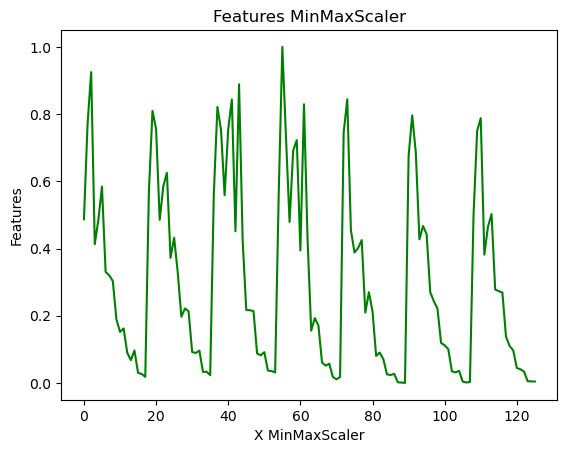

	 Original features 126
	 Selected features 68
	 Percentage of selected rules: 53.96825396825397 %
->Generate new tree based on list
Elapsed time to compute the binary_tree_generator: 11642.536 seconds
->Generate obtained patterns tree
Elapsed time to compute the obtain_pattern_list_of_valid_nodes_with_pvalue: 287.075 seconds
->Categorize patterns
Elapsed time to compute the categorize_patterns: 58.763 seconds


In [5]:
from iPRules.iPRules import iPRules

rules = iPRules(
                feature_names=dataset.feature_names,
                target_value_name = dataset.target_names,
                display_features = True,
                display_logs = True,
                chi_square_percent_point_function = 0.95,
                scale_feature_coefficient = 0.2,
                min_accuracy_coefficient = 0.9,
                min_number_class_per_node = 3
            )
# Fit model
rules.fit(encoded_train_pandas_dataset, ensemble.feature_importances_)

# Print Model

In [6]:
print(rules)

> ++++++++++++++++++++++++++++
> iPRules --  Number of Rules 1048:
> ++++++++++++++++++++++++++++
> ------------------------------
 ** Target value: True ** Target: 68 ** Total: 68 ** Accuracy: 1.0 ** Complexity: 14 ** Chi2 critical_value: 3.841458820694124 ** P_value: 6.213557980077166e-05
	 Query: F19_o == False  &  F1_x == False  &  F15_o == False  &  F25_o == False  &  F14_x == False  &  F21_o == False  &  F13_o == False  &  F7_o == False  &  F31_o == False  &  F37_x == False  &  F1_o == False  &  F14_o == False  &  F7_x == True  &  F13_x == True
> ------------------------------
> ------------------------------
 ** Target value: True ** Target: 42 ** Total: 42 ** Accuracy: 1.0 ** Complexity: 17 ** Chi2 critical_value: 3.841458820694124 ** P_value: 1.565664659677744e-05
	 Query: F19_o == False  &  F1_x == False  &  F15_o == False  &  F25_o == False  &  F14_x == False  &  F21_o == False  &  F13_o == False  &  F7_o == False  &  F31_o == False  &  F37_x == False  &  F1_o == False  &  F

# Predict

In [7]:
# ENSEMBLE
y_pred_test_ensemble = ensemble.predict(X_test)

# RULES
y_pred_test_rules = rules.predict(X_test, sorting_method="target_accuracy")

In [8]:
# CATEGORIZABLES
np_array_rules = np.array(y_pred_test_rules)
#not_filter_indices = np.where(np.logical_and(np_array_rules != 0, np_array_rules!=1))[0]
filter_indices = np.where(np_array_rules != None)[0]


np_filterred_y_test = np.array(y_test)[filter_indices]
np_filterred_y_pred_test_ensemble = np.array(y_pred_test_ensemble)[filter_indices]
np_filterred_y_pred_test_rules = np.array(y_pred_test_rules)[filter_indices]
# CHANGE FORMAT IN ORDER TO NOT HAVE PROBLEMS
np_filterred_y_pred_test_rules = np_filterred_y_pred_test_rules.astype('int64')


print(f'DATASET TEST: {len(y_test)}')
print(f'DATASET TEST categorizable: {len(np_filterred_y_test)}')
print('Cobertura:',str("{:.2f}".format(100*(len(np_filterred_y_pred_test_rules)/len(y_test))))+'%')

ensemble_accuracy = metrics.accuracy_score(np_filterred_y_test, np_filterred_y_pred_test_ensemble)
print('RF accuracy:',str("{:.2f}".format(100*ensemble_accuracy))+'%')
ensemble_accuracy = metrics.f1_score(np_filterred_y_test, np_filterred_y_pred_test_ensemble)
print('RF F1-score:',str("{:.2f}".format(100*ensemble_accuracy))+'%')
rules_accuracy = metrics.accuracy_score(np_filterred_y_test, np_filterred_y_pred_test_rules)
print('Rules Accuracy:',str("{:.2f}".format(100*rules_accuracy))+'%')
rules_accuracy = metrics.f1_score(np_filterred_y_test, np_filterred_y_pred_test_rules)
print('Rules F1-score:',str("{:.2f}".format(100*rules_accuracy))+'%')
rules_accuracy = metrics.roc_auc_score(np_filterred_y_test, np_filterred_y_pred_test_rules)
print('Rules roc_auc_score:',str("{:.2f}".format(100*rules_accuracy))+'%')


DATASET TEST: 13512
DATASET TEST categorizable: 6804
Cobertura: 50.36%
RF accuracy: 93.24%
RF F1-score: 95.75%
Rules Accuracy: 91.15%
Rules F1-score: 94.48%
Rules roc_auc_score: 83.77%


# SHAP explainer

In [ ]:
import shap

# Create Tree Explainer object that can calculate shap values
explainer = shap.TreeExplainer(ensemble)

# Evaluate SHAP values
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_train, feature_names=dataset.feature_names)


Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display


In [ ]:

shap.summary_plot(shap_values, X_train, feature_names=dataset.feature_names, plot_type="dot")